## Example for plotting tracked eddy composites 
### Identify, track and composite eddy along its track (SSH fields) 
howto-IDtrackcompeddy-daily.ipynb
### Pull out other fields associated with tracked eddy
howto-eddycompositeotherfields-daily.ipynb



### Now plot tracks and composites

In [1]:
import os 
import numpy as np
from datetime import datetime, timedelta
import xarray as xr


In [2]:
expid='erc1011'
fq='dm'
eddydir='reg25/'+expid+'/eddytrack/ssh/'+fq+'/'
tracker_dir=eddydir+'tracks/'
figpath='~/figs/EERIE/erc1011/eddytrack/'

# eddy_type='cyclonic'
eddy_type='anticyclonic'

dscorres = xr.open_dataset(tracker_dir+expid+'_'+eddy_type+'_'+fq+'_correspondance.nc')
dstracks = xr.open_dataset(tracker_dir+eddy_type+'_tracks.nc')
dsshort = xr.open_dataset(tracker_dir+eddy_type+'_short.nc')
dsuntrack = xr.open_dataset(tracker_dir+eddy_type+'_untracked.nc')


In [3]:
wavelength=700
dlon=2.5
dlat=2.5
res=0.25
npts=int(dlon/res) #number of points from centre


In [4]:
#Get desired region [Agulhas leakage in this case]
ARidx = np.argwhere((dstracks.latitude.values<=-30) & (dstracks.latitude.values>=-45) &
                     (dstracks.longitude.values>5) & (dstracks.longitude.values<25))


#Get track IDs for Agulhas rings, remove all duplicates
ARtrackid=np.array(sorted(list(set(dstracks.track.values[ARidx].squeeze()))))
# print('Track IDs=',ARtrackid)

#Get number of obs for each track for Agulhas rings
trackIDs=dstracks.track.values
tracklen=[]
for ii in range(trackIDs.max()+1):
    tracklen.append(len(np.argwhere(trackIDs == ii)))
lentrack=np.array(tracklen)[ARtrackid]
# print('No. of obs for each tracked ID =',lentrack)

#Remove tracks with less than 90 days
newARtrackid=np.delete(ARtrackid,np.r_[np.argwhere(lentrack<60)])
print('Track IDs that last more than 60 days=',newARtrackid)
lentrack=np.array(tracklen)[newARtrackid]
print('No. of obs for each tracked ID =',lentrack)
del(tracklen)


Track IDs that last more than 60 days= [  351  1212  1520  1909  2231  3020  3521  3854  4692  4715  6432  7649
  8000  8793  8873  9314  9956 10418]
No. of obs for each tracked ID = [127  66 154  70 227 155  65  72  76  77  63  96  68  72 123  85  89  76]


In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import matplotlib.ticker as mticker

/tmp/ipykernel_1396635/2993098262.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm,orientation='horizontal')


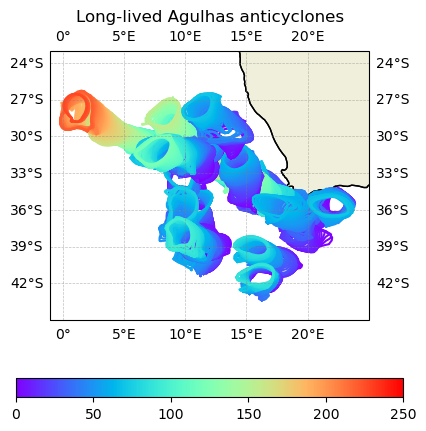

In [6]:
fig = plt.figure(figsize=(5, 5))
#ax = fig.add_axes([0.05, 0.03, 0.90, 0.94])

projection = ccrs.PlateCarree(central_longitude=5)
# projection = ccrs.LambertConformal(central_longitude=5, central_latitude=-35)
ax = plt.axes(projection=projection)
ax.coastlines()
ax.add_feature(cfeature.LAND,zorder=1,edgecolor='k')

for tridx in newARtrackid:
    con_lon=dstracks.effective_contour_longitude.values[np.argwhere(dstracks.track.values==tridx)].squeeze()
    con_lat=dstracks.effective_contour_latitude.values[np.argwhere(dstracks.track.values==tridx)].squeeze()
    con_lon=np.where(con_lon>350,con_lon-360,con_lon)
    color = iter(cm.rainbow(np.linspace(0, 1, 250)))
    for tt in range(con_lon.shape[0]):
        cline = next(color)
        ax.plot(con_lon[tt,:],con_lat[tt,:], c=cline)

ax.set_title('Long-lived Agulhas anticyclones')
ax.set_extent([-1, 25, -45, -23], ccrs.PlateCarree())
ax.gridlines(color='gray',linestyle='--',linewidth=0.5,draw_labels=True, alpha=0.5)
ax.xlocator = mticker.FixedLocator(np.arange(-5,25,5))
ax.xformatter = LONGITUDE_FORMATTER
ax.ylocator = mticker.FixedLocator(np.arange(-45,-20,5))
ax.yformatter = LATITUDE_FORMATTER
ax.xlabels_top = False
ax.ylabels_right = False

sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=plt.Normalize(vmin=0, vmax=250))
plt.colorbar(sm,orientation='horizontal')

plt.show()


In [7]:
def build_composite(newARtrackid,fprefix,varname):
    FIELDcomp=[]
    SSHcomp=[]
    for tridx in newARtrackid:
        # print('Load fields for eddy track ',tridx)
    
        #Load composite dataset
        fileout=fprefix+str(tridx)+'.nc'
        dsFIELD=xr.open_dataset(fileout)
        # print('Lifetime of eddy# '+str(tridx)+' = '+ str(len(dsFIELD.n)))
        # print('eddy center (lon,lat) = ('+str(dsFIELD.lon.values.mean())+', '+str(dsFIELD.lat.values.mean())+')')
    
        FIELDpercomp=dsFIELD[varname]
        SSHpercomp=dsFIELD.ssh
        # print(FIELDpercomp.shape)
        #mean of each eddy
        FIELDcomp.append(xr.concat(FIELDpercomp[:,:,:],dim='eddy').mean(dim='eddy'))
        SSHcomp.append(xr.concat(SSHpercomp[:,:,:],dim='eddy').mean(dim='eddy'))
    
    avgSSHcomp=xr.concat(SSHcomp,dim='eddy').mean(dim='eddy')
    avgFIELDcomp=xr.concat(FIELDcomp,dim='eddy').mean(dim='eddy')
    return avgSSHcomp, avgFIELDcomp

def plot_composite(avgSSHcomp,avgFIELDcomp,varname,vmin,vmax,figprefix):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_axes([0.05, 0.05, 0.94, 0.92])
    CM=ax.pcolormesh(avgFIELDcomp.x,avgFIELDcomp.y,avgFIELDcomp,cmap='RdBu_r',shading='gouraud',vmin=vmin,vmax=vmax)
    CS=ax.contour(avgSSHcomp.x,avgSSHcomp.y,avgSSHcomp,levels=[0.,0.1,0.2,0.3],colors='k')
    ax.clabel(CS, fontsize=9, inline=True)
    plt.colorbar(CM,orientation='vertical')
    # ax.set_title(varname)
    # fig.savefig(figprefix+varname+'_2002-2008.png')
    


In [8]:
fprefix=tracker_dir+expid+'_'+eddy_type+'_'+str(dlon)+'x'+str(dlat)+'deg_trackID_'
figprefix=figpath+expid+'_AR'+eddy_type+'_avgeddycomp_'


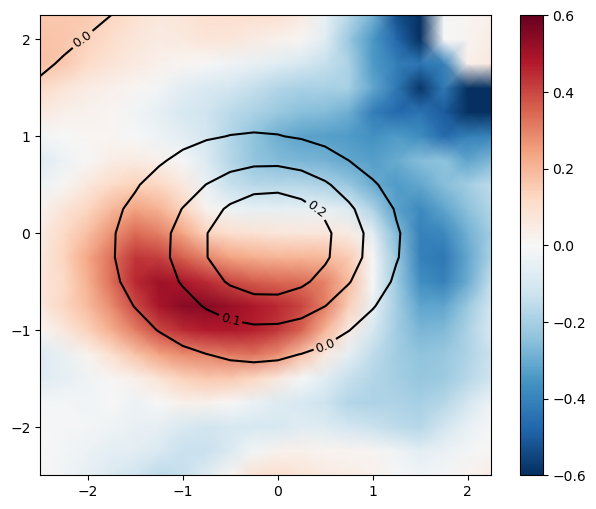

In [9]:
varname='to' #SST
vmin=-0.6
vmax=0.6
fac=1

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)



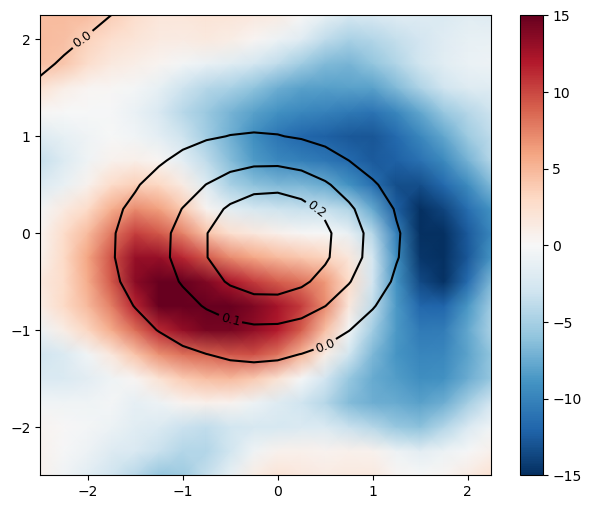

In [10]:
varname='hfls' #latent heat flux
vmin=-15
vmax=15
fac=-1 #positive flux out of ocean

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)


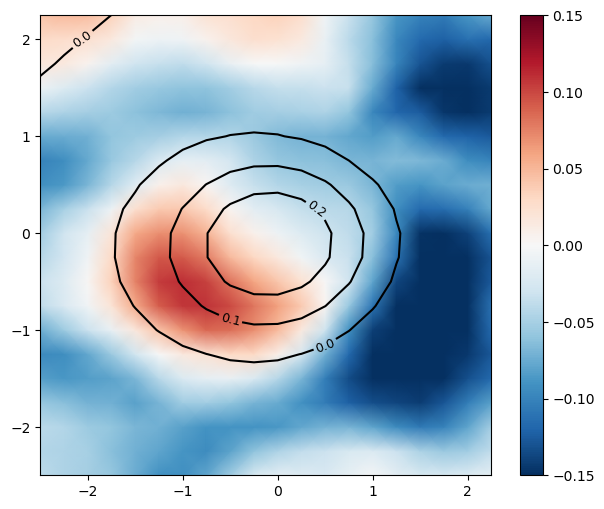

In [11]:
varname='sfcwind'
vmin=-0.15
vmax=0.15
fac=1

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)


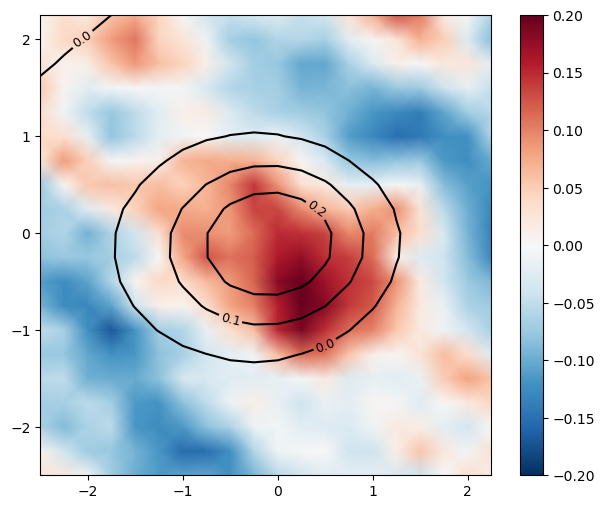

In [12]:
varname='pr' #precipitation
vmin=-0.2
vmax=0.2
fac=1000*86400/1000 #convert from kg/m2/s to mm/day

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)


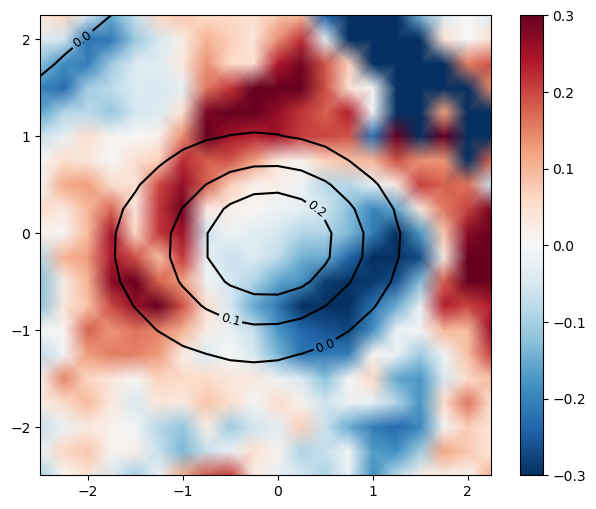

In [13]:
varname='downSSTgrad' #downwind SST gradients
vmin=-0.3
vmax=0.3
fac=1e5 #convert to per 100km

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)


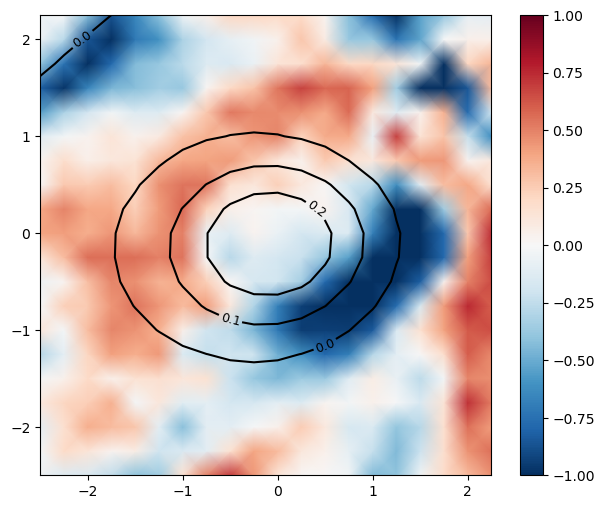

In [14]:
varname='taudiv' #windstress divergence
vmin=-1
vmax=1
fac=1e7 #convert to per 10,000km

avgSSHcomp,avgFIELDcomp = build_composite(newARtrackid,fprefix,varname)
plot_composite(avgSSHcomp,avgFIELDcomp*fac,varname,vmin,vmax,figprefix)
